Customers DataFrame columns: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Transactions DataFrame columns: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')
New dataset columns after encoding: Index(['CustomerID', 'CustomerName', 'SignupDate', 'TransactionID',
       'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price',
       'TransactionCount', 'AverageTransaction', 'Region_Europe',
       'Region_North America', 'Region_South America'],
      dtype='object')


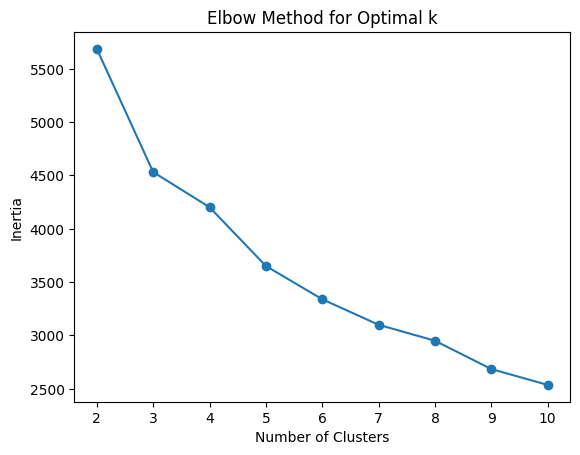

Davies-Bouldin Index: 1.602620528368368


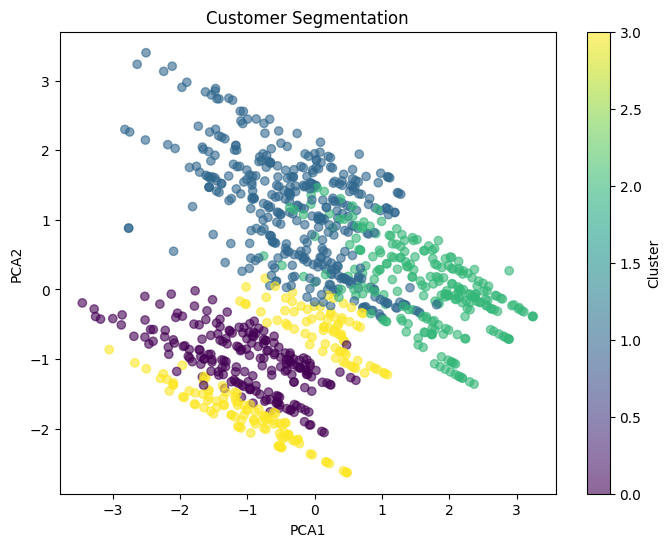

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Load the customer and transaction data (adjust the file paths accordingly)
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Check the column names to ensure they match the expected column names
print("Customers DataFrame columns:", customers_df.columns)
print("Transactions DataFrame columns:", transactions_df.columns)

# Ensure column name consistency in both data frames
if 'CustomerID' in customers_df.columns and 'CustomerID' in transactions_df.columns:
    # Merge the customer and transaction data on 'CustomerID'
    data = customers_df.merge(transactions_df, on='CustomerID', how='left')
else:
    print("Error: 'CustomerID' column is missing in one of the data frames.")
    # Handle the error or stop execution
    exit()

# Handle missing values in the data
data.fillna(0, inplace=True)

# Feature Creation: Calculate new features like TransactionCount and AverageTransaction
data['TransactionCount'] = data.groupby('CustomerID')['TotalValue'].transform('count')
data['AverageTransaction'] = data.groupby('CustomerID')['TotalValue'].transform('mean')

# One-Hot Encoding of the 'Region' column
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

# Inspect new columns after one-hot encoding
print("New dataset columns after encoding:", data.columns)

# Update the features list to include the new region columns
features = ['SignupDate', 'TotalValue', 'TransactionCount', 'AverageTransaction'] + [col for col in data.columns if 'Region_' in col]

# Convert 'SignupDate' to numeric (timestamp)
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['SignupDate'] = data['SignupDate'].astype(np.int64) // 10**9  # Convert to Unix timestamp in seconds

# Preprocess categorical and numerical columns: scale them
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to determine the optimal number of clusters (between 2 and 10)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans clustering (example optimal_k = 4 after inspecting the elbow plot)
optimal_k = 4  # Example chosen from elbow plot

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Evaluate clustering using Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(X_scaled, data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters using PCA for dimensionality reduction (2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add PCA components to the dataframe
data['PCA1'] = pca_components[:, 0]
data['PCA2'] = pca_components[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data['PCA1'], data['PCA2'], c=data['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()
